<a href="https://colab.research.google.com/github/iremakalp/Plant_Disease_Detection/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **1.1. Import Required Libraries**



In [ ]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

#### **1.2. Test-Train Data**
**Split the dataset**

In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0

  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ='/content/drive/MyDrive/d'
test_dir='/content/drive/MyDrive/train'

In [ ]:
import os
import random
import shutil

# Path to the main directory containing your dataset
main_dir = "/content/drive/MyDrive/d"

# Path to the directory where you want to store the selected subset of images
subset_dir = "/content/drive/MyDrive/subset1"

# Number of images to select from each directory
num_images_per_directory = 50

# Iterate through each subdirectory directly within the main directory
for subdir_name in os.listdir(main_dir):
    subdirectory_path = os.path.join(main_dir, subdir_name)

    # Check if the path is a directory
    if os.path.isdir(subdirectory_path):
        # List all files in the subdirectory
        files = os.listdir(subdirectory_path)

        # Randomly select num_images_per_directory files
        selected_files = random.sample(files, min(num_images_per_directory, len(files)))

        # Create a directory in the subset directory corresponding to the subdirectory
        subset_subdir = os.path.join(subset_dir, subdir_name)
        os.makedirs(subset_subdir, exist_ok=True)

        # Copy or move the selected files to the subset directory
        for file in selected_files:
            file_path = os.path.join(subdirectory_path, file)
            shutil.copy(file_path, subset_subdir)  # Change to shutil.move if you want to move the files instead of copying

        print(f"Selected {len(selected_files)} images from {subdir_name} directory.")

print("Selection process completed.")


Selected 50 images from Tomato___Spider_mites Two-spotted_spider_mite directory.
Selected 50 images from Tomato___Early_blight directory.
Selected 50 images from Tomato___Septoria_leaf_spot directory.
Selected 50 images from Tomato___Target_Spot directory.
Selected 50 images from Tomato___Tomato_Yellow_Leaf_Curl_Virus directory.
Selected 50 images from Tomato___healthy directory.
Selected 50 images from Tomato___Bacterial_spot directory.
Selected 50 images from Tomato___Late_blight directory.
Selected 50 images from Tomato___Leaf_Mold directory.
Selected 50 images from Tomato___Tomato_mosaic_virus directory.
Selection process completed.


In [ ]:
test_dir='/content/drive/MyDrive/subset1'
subset_dir='/content/drive/MyDrive/subset1'

In [ ]:
import os
import glob

train_samples = get_files(train_dir)
test_samples = get_files(subset_dir)
num_classes = len(glob.glob(os.path.join(train_dir, "*")))

# Print dataset information
print(num_classes, "Classes")
print(train_samples, "Train images")
print(test_samples, "Test images")


10 Classes
3581 Train images
1212 Test images


<ipython-input-7-39d5f2c348af>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts, y=class_names, palette="viridis")


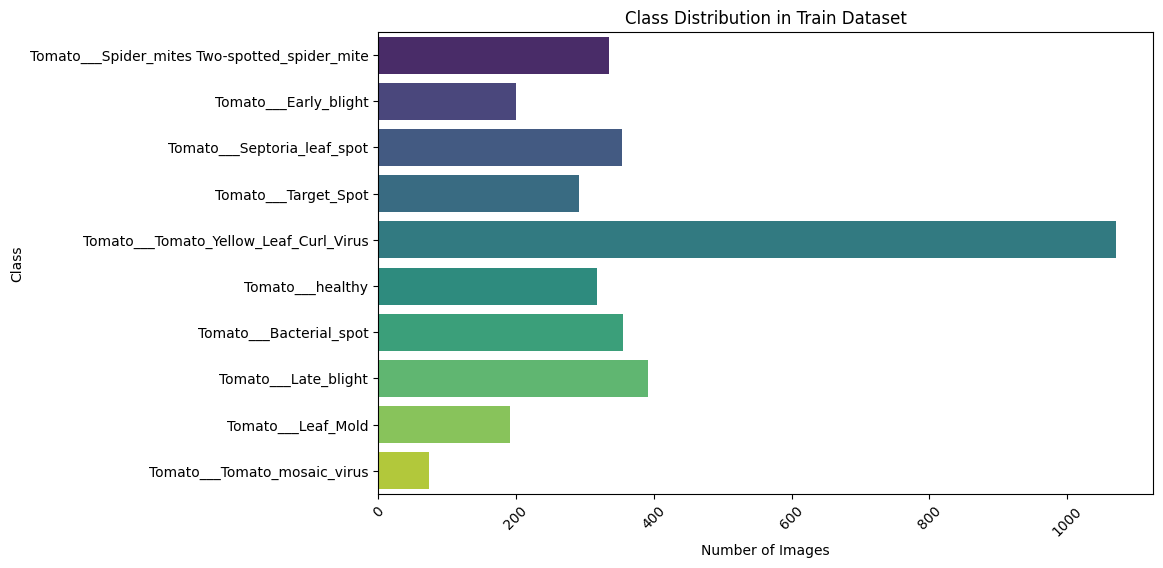

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Define your function to get the number of files in a directory
def get_files(directory):
    # Use os.listdir to get a list of files in the directory
    files = os.listdir(directory)
    # Return the length of the list (number of files)
    return len(files)

# Get class names
class_names = [os.path.basename(class_dir) for class_dir in glob.glob(os.path.join(train_dir, "*"))]

# Get image counts per class
class_counts = [get_files(os.path.join(train_dir, class_dir)) for class_dir in class_names]

# Plotting
plt.figure(figsize=(10, 6))

# Plot class distribution
sns.barplot(x=class_counts, y=class_names, palette="viridis")
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.title('Class Distribution in Train Dataset')
plt.xticks(rotation=45)
plt.show()


<ipython-input-8-db3a73aa7293>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts, y=class_names, palette="viridis")


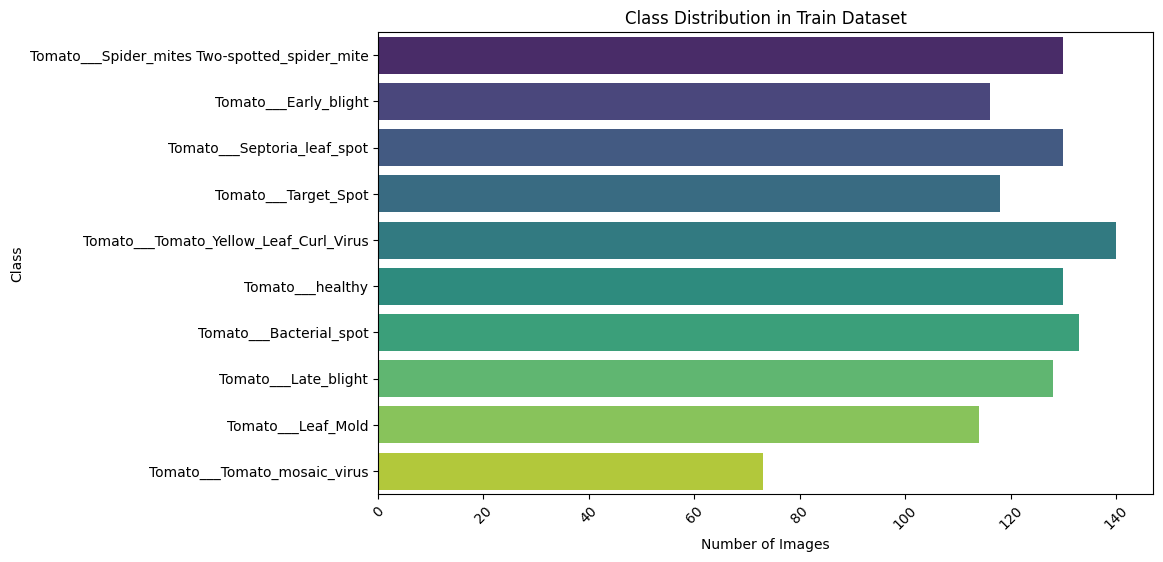

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Define your function to get the number of files in a directory
def get_files(directory):
    # Use os.listdir to get a list of files in the directory
    files = os.listdir(directory)
    # Return the length of the list (number of files)
    return len(files)

# Get class names
class_names = [os.path.basename(class_dir) for class_dir in glob.glob(os.path.join(test_dir, "*"))]

# Get image counts per class
class_counts = [get_files(os.path.join(test_dir, class_dir)) for class_dir in class_names]

# Plotting
plt.figure(figsize=(10, 6))

# Plot class distribution
sns.barplot(x=class_counts, y=class_names, palette="viridis")
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.title('Class Distribution in Train Dataset')
plt.xticks(rotation=45)
plt.show()


In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
input_shape=(224,224,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)
test_generator=test_datagen.flow_from_directory(subset_dir,shuffle=True,target_size=(224,224),batch_size=32)

Found 3581 images belonging to 10 classes.
Found 1212 images belonging to 10 classes.


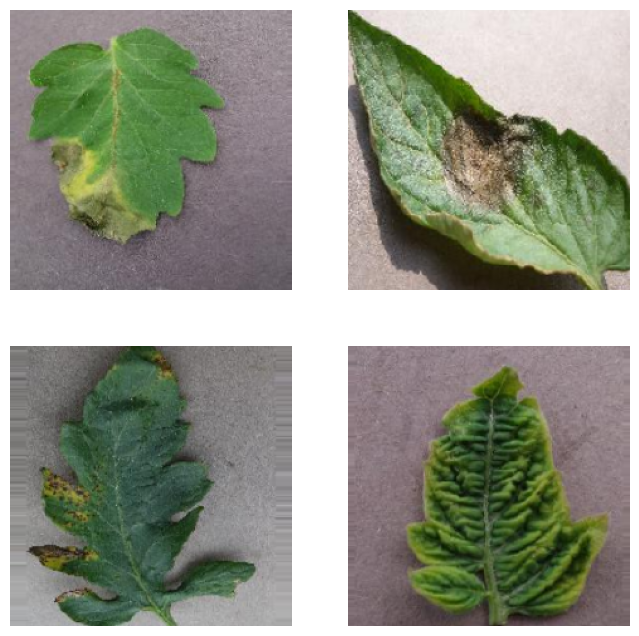

In [ ]:
import matplotlib.pyplot as plt

# Generate a batch of preprocessed images from the train generator
train_batch = train_generator.next()

# Plot the images
plt.figure(figsize=(8, 8))  # Adjust the figure size here

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(train_batch[0][i], aspect='auto')  # Adjust the aspect ratio of the image
    plt.axis('off')

plt.show()


#### **1.3. CNN Model**

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu',name="conv2d_1"))
model.add(MaxPooling2D(pool_size=(3, 3),name="max_pooling2d_1"))
model.add(Conv2D(32, (3, 3),activation='relu',name="conv2d_2"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_2"))
model.add(Conv2D(64, (3, 3),activation='relu',name="conv2d_3"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_3"))
model.add(Flatten(name="flatten_1"))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 33, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       subset_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 1212 images belonging to 10 classes.


In [ ]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
history1 = model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True
    )

Epoch 1/50
112/112 [==============================] - 369s 3s/step - loss: 1.7068 - accuracy: 0.4136 - val_loss: 1.5006 - val_accuracy: 0.4728 - lr: 0.0010
Epoch 2/50
112/112 [==============================] - 75s 675ms/step - loss: 1.0288 - accuracy: 0.6462 - val_loss: 1.1779 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 3/50
112/112 [==============================] - 75s 674ms/step - loss: 0.7881 - accuracy: 0.7314 - val_loss: 0.8247 - val_accuracy: 0.7054 - lr: 0.0010
Epoch 4/50
112/112 [==============================] - 75s 670ms/step - loss: 0.6647 - accuracy: 0.7721 - val_loss: 0.6916 - val_accuracy: 0.7607 - lr: 0.0010
Epoch 5/50
112/112 [==============================] - 78s 695ms/step - loss: 0.6189 - accuracy: 0.7886 - val_loss: 0.6388 - val_accuracy: 0.7921 - lr: 0.0010
Epoch 6/50
112/112 [==============================] - 73s 657ms/step - loss: 0.5634 - accuracy: 0.8073 - val_loss: 0.4325 - val_accuracy: 0.8540 - lr: 0.0010
Epoch 7/50
112/112 [==============================] - 

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_Cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error

# Predicting labels for test data
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Precision
precision = precision_score(y_true, y_pred_classes, average='micro')

# Recall
recall = recall_score(y_true, y_pred_classes, average='micro')

# F1 Score
f1 = f1_score(y_true, y_pred_classes, average='micro')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Mean Squared Error
mse = mean_squared_error(y_true, y_pred_classes)

# Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


38/38 [==============================] - 19s 488ms/step
Accuracy: 0.09570957095709572
Precision: 0.09570957095709572
Recall: 0.09570957095709572
F1 Score: 0.09570957095709572
Confusion Matrix:
 [[16  9 10 15 13 17 16 18  4 15]
 [16  8 16 17  9 11  6 14  7 12]
 [15 14  6 10 17 16 12 16 11 11]
 [ 8 13 13 10 11 11  9  9  9 21]
 [16 12 15 18 16 14  8 12  7 12]
 [12 16 17  9 13 13 10 21  6 13]
 [12 16 13 11 10 11 12 12 10 11]
 [20 11 14 13 11 14 16 17  9 15]
 [ 7  4 13  3 12 10 11  5  3  5]
 [11 13 11  8 18 12 19 16  7 15]]
Mean Squared Error: 16.24009900990099
Mean Absolute Error: 3.291254125412541


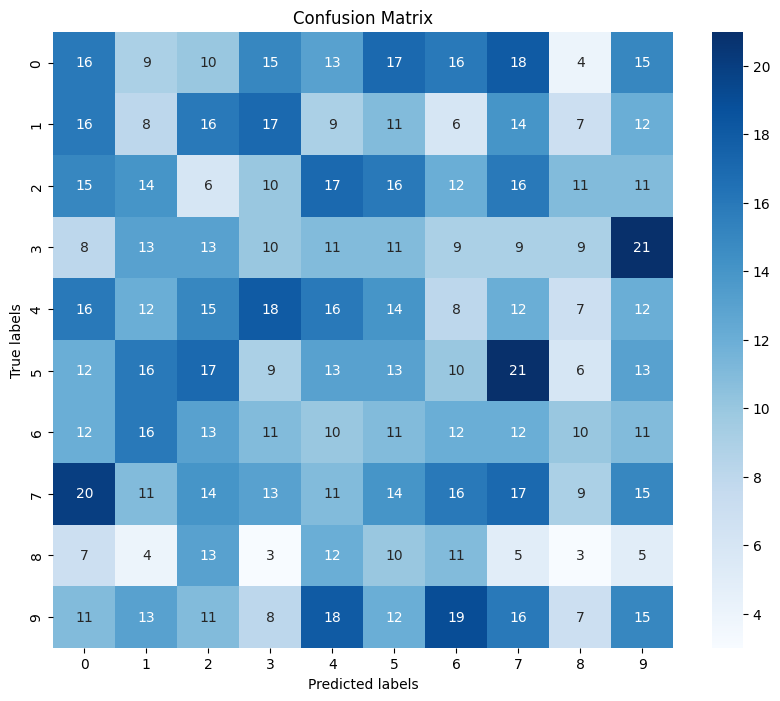

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


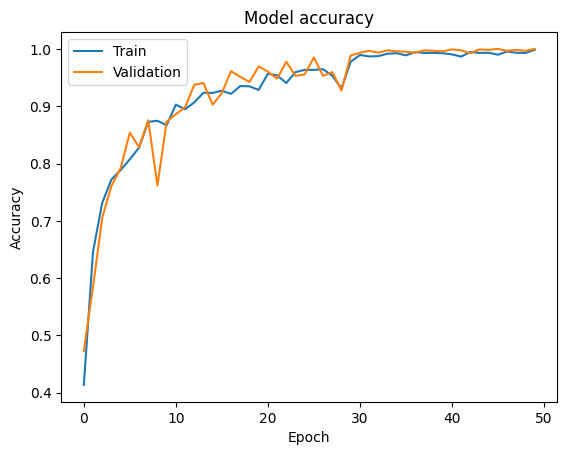

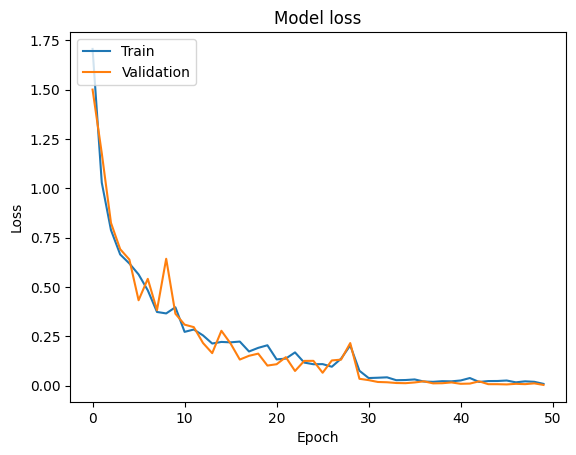

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#### **1.4. InceptionV3 Modeli**

The model will be downloaded automatically the first time the command is run to create the model. Assigning the weight parameter to the imagenet will enable the weights of the imagenet model to be used. If we want to train something using the Inception mesh, the weight parameter can be set to None, that way the weights will be randomly generated with default values.

In [ ]:
IMAGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Model layers
x = Flatten()(inception.output)
prediction = Dense(num_classes, activation='softmax')(x)
# Create a model object
model = Model(inputs=inception.input, outputs=prediction)
# View the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       subset_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 1212 images belonging to 10 classes.


In [ ]:
# Defining the cost and model optimization method to use
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history4 = model.fit(
    train_generator,#egitim verileri
    steps_per_epoch=None,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True)

Epoch 1/50
112/112 [==============================] - 1693s 15s/step - loss: 4.2004 - accuracy: 0.6194 - val_loss: 2.0681 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 2/50
112/112 [==============================] - 72s 645ms/step - loss: 1.4787 - accuracy: 0.7869 - val_loss: 2.5093 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 3/50
112/112 [==============================] - 73s 657ms/step - loss: 1.5361 - accuracy: 0.8001 - val_loss: 1.6896 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 4/50
112/112 [==============================] - 72s 645ms/step - loss: 1.4388 - accuracy: 0.8280 - val_loss: 1.2383 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 5/50
112/112 [==============================] - 74s 664ms/step - loss: 1.2401 - accuracy: 0.8581 - val_loss: 1.0096 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 6/50
112/112 [==============================] - 72s 646ms/step - loss: 1.0931 - accuracy: 0.8707 - val_loss: 1.3426 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 7/50
112/112 [==============================] 

In [ ]:
# Saving the model as a h5 file
model.save('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_inception.h5')

38/38 [==============================] - 21s 503ms/step
Accuracy: 0.10478547854785479
Precision: 0.10478547854785479
Recall: 0.10478547854785479
F1 Score: 0.1047854785478548
Confusion Matrix:
 [[16 10 10 10 18 13 11 18 10 17]
 [18 14 12 13 10 12 10 11  3 13]
 [13 10 14 14 16 14 20  9  6 12]
 [ 8 10 12 17 12 14 13 16  4  8]
 [13 15 19 12  7 13 12 14 12 13]
 [11 11 14  9 23 17 10 12  8 15]
 [12  8 16  7 13 10  9 19  6 18]
 [16 13 15 16 12 12 11 17 15 13]
 [11  9  5  9  7  6  6 12  2  6]
 [13 16 10  7 16 18 15 14  7 14]]
Mean Squared Error: 16.125412541254125
Mean Absolute Error: 3.235973597359736


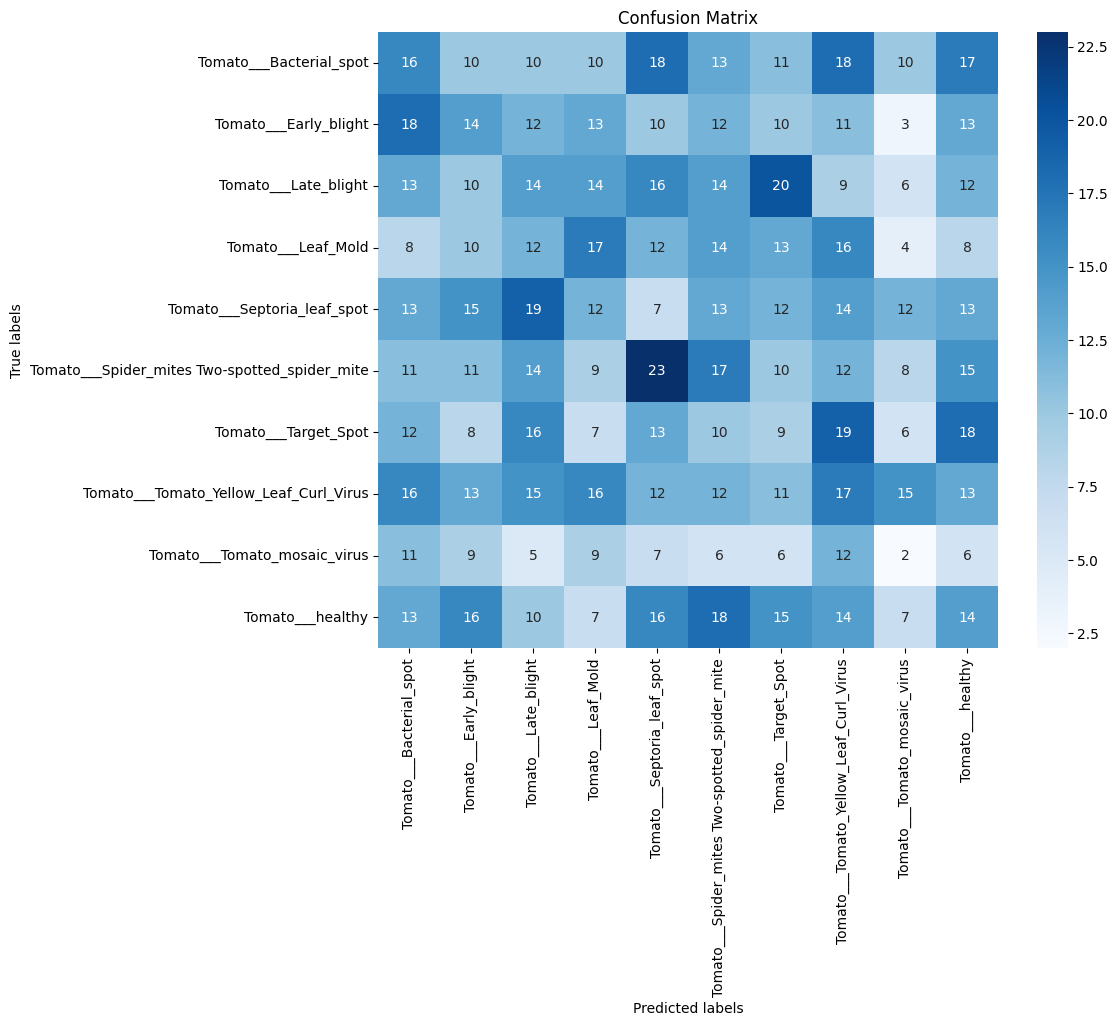

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error

# Predicting labels for test data
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Precision
precision = precision_score(y_true, y_pred_classes, average='micro')

# Recall
recall = recall_score(y_true, y_pred_classes, average='micro')

# F1 Score
f1 = f1_score(y_true, y_pred_classes, average='micro')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Mean Squared Error
mse = mean_squared_error(y_true, y_pred_classes)

# Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=validation_generator.class_indices,
            yticklabels=validation_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



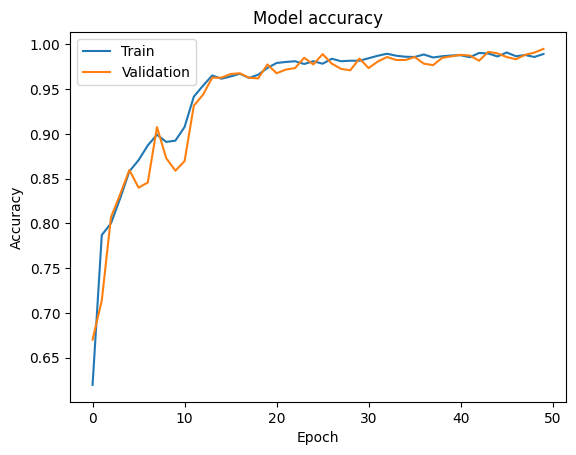

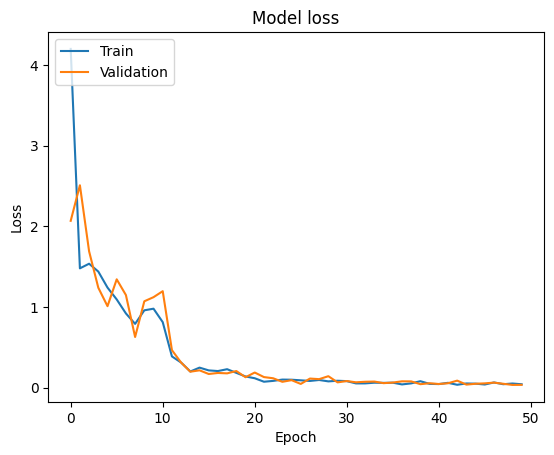

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#### **1.5. AlexNet**

This deep convolutional neural network consisting of 25 layers consists of 5 convolution layers, 3 maxpool layers, 2 dropout layers, 3 fully connected layers, 7 relu layers, 2 normalization layers, softmax layer, input and classification (output) layers. .

In [ ]:
# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [ ]:
num_classes=10

In [ ]:
# Initializing the CNN
model = Sequential()
# Convolution Step 1
model.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))
# Max Pooling Step 1
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())
# Convolution Step 2
model.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))
# Max Pooling Step 2
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
model.add(BatchNormalization())
# Convolution Step 3
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())
# Convolution Step 4
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())
# Convolution Step 5
model.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))
# Max Pooling Step 3
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())
# Flattening Step
model.add(Flatten())
# Full Connection Step
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 1000, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units = num_classes, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization_94 (Ba  (None, 27, 27, 96)        384       
 tchNormalization)                                               
                                                                 
 conv2d_95 (Conv2D)          (None, 17, 17, 256)       2973952   
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                            
                                                        

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       subset_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 1212 images belonging to 10 classes.


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history5 = model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=4,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True)

Epoch 1/50
112/112 [==============================] - 67s 501ms/step - loss: 2.0061 - accuracy: 0.4354 - val_loss: 4.3660 - val_accuracy: 0.1641 - lr: 0.0010
Epoch 2/50
112/112 [==============================] - 56s 500ms/step - loss: 1.4214 - accuracy: 0.5314 - val_loss: 2.1093 - val_accuracy: 0.3828 - lr: 0.0010
Epoch 3/50
112/112 [==============================] - 55s 492ms/step - loss: 1.2753 - accuracy: 0.5912 - val_loss: 1.9544 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 4/50
112/112 [==============================] - 55s 493ms/step - loss: 1.0303 - accuracy: 0.6593 - val_loss: 4.4445 - val_accuracy: 0.2734 - lr: 0.0010
Epoch 5/50
112/112 [==============================] - 56s 501ms/step - loss: 0.9898 - accuracy: 0.6777 - val_loss: 4.0735 - val_accuracy: 0.1953 - lr: 0.0010
Epoch 6/50
112/112 [==============================] - 57s 505ms/step - loss: 0.8917 - accuracy: 0.7054 - val_loss: 6.8607 - val_accuracy: 0.1797 - lr: 0.0010
Epoch 7/50
112/112 [==============================] 

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MyModels/model__Alexnet.h5')

38/38 [==============================] - 19s 486ms/step
Accuracy: 0.10066006600660066
Precision: 0.10066006600660066
Recall: 0.10066006600660066
F1 Score: 0.10066006600660064
Confusion Matrix:
 [[13 13 13  4 20 17 18 10 11 14]
 [16  9  7 14  6 14 13 15  8 14]
 [13  9 11 10 14 18 14 17  7 15]
 [10 15 13 12 12 12 16 11  4  9]
 [15 15 15 14 12 12  7 17  8 15]
 [15  8 14 15 19 15  8 19  8  9]
 [10 11 13 13 11 10 10 13  9 18]
 [15 14 18 14 15 16 13 18  4 13]
 [ 7 10  4  4 12  7  8  8  6  7]
 [17 12 20 12 13  9  9 14  8 16]]
Mean Squared Error: 16.863036303630363
Mean Absolute Error: 3.3465346534653464


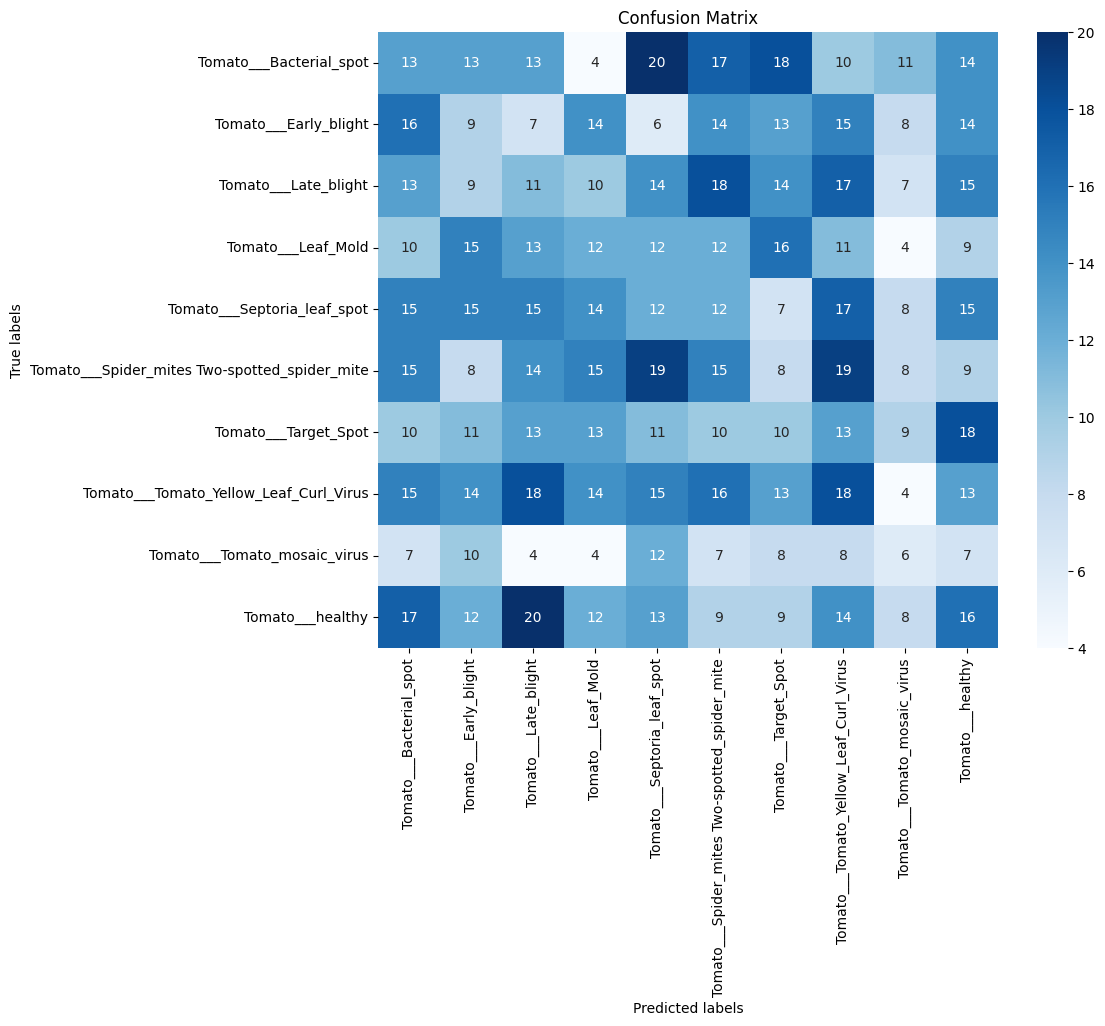

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error

# Predicting labels for test data
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Precision
precision = precision_score(y_true, y_pred_classes, average='micro')

# Recall
recall = recall_score(y_true, y_pred_classes, average='micro')

# F1 Score
f1 = f1_score(y_true, y_pred_classes, average='micro')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Mean Squared Error
mse = mean_squared_error(y_true, y_pred_classes)

# Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=validation_generator.class_indices,
            yticklabels=validation_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
model_alexnet = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/MyModels/model__Alexnet.h5')

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model_alexnet.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
38/38 [==============================] - 17s 450ms/step - loss: 0.0332 - accuracy: 0.9909
Test Accuracy: 99.09241199493408


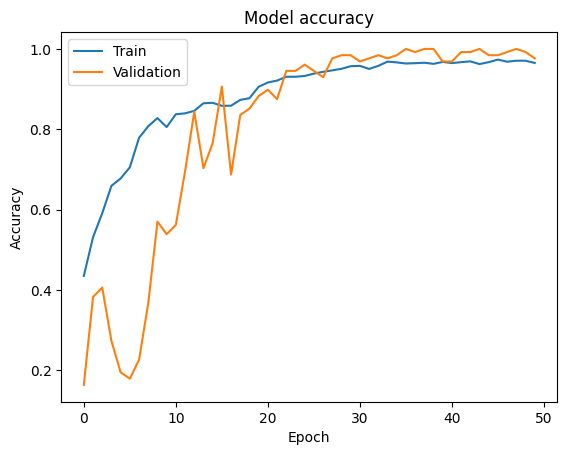

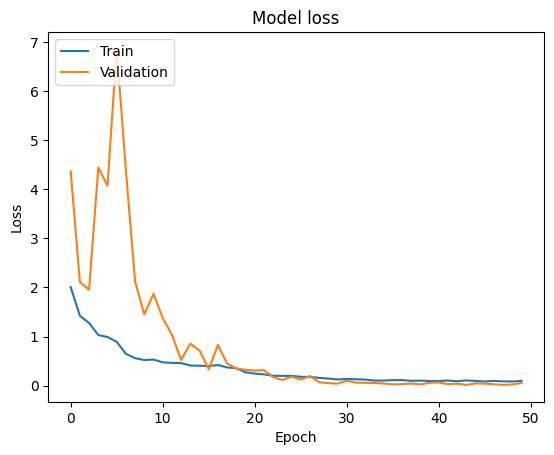

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


testing


#### **2.1. CNN Model**

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_cnn=load_model('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_Cnn.h5')

In [ ]:
print("[INFO] Calculating model accuracy")
scores =model_cnn.evaluate(validation_generator)
cnn={scores[1]*100}
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
38/38 [==============================] - 50s 1s/step - loss: 0.0036 - accuracy: 1.0000
Test Accuracy: 100.0


1/1 [==============================] - 0s 307ms/step
Tomato___Bacterial_spot


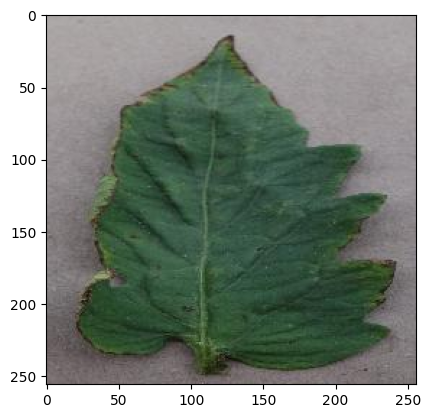

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='/content/drive/MyDrive/subset/Tomato___Bacterial_spot/01d9fc8d-5083-468d-a583-885f33517cdd___GCREC_Bact.Sp 3422.JPG'
result_cnn = model_cnn.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_cnn,axis=1)
predic=classes[classresult[0]]
print(classes[classresult[0]])

#### **2.2. Inception Model**

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_inception=load_model('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_inception.h5')

In [ ]:
print("[INFO] Calculating model accuracy")
scores =model_inception.evaluate(validation_generator)
incep={scores[1]*100}
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
38/38 [==============================] - 186s 5s/step - loss: 0.0836 - accuracy: 0.9835
Test Accuracy: 98.34983348846436


1/1 [==============================] - 3s 3s/step
Tomato___Bacterial_spot


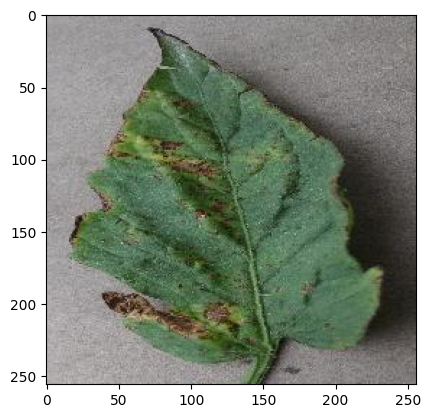

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='/content/drive/MyDrive/subset1/subset1/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'

result_inception = model_inception.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_inception,axis=1)

print(classes[classresult[0]])

#### **2.3. AlexNet Model**

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_alexnet=load_model('/content/drive/MyDrive/Colab Notebooks/MyModels/model__Alexnet.h5')

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model_alexnet.evaluate(validation_generator)
alex={scores[1]*100}
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
38/38 [==============================] - 98s 3s/step - loss: 0.0607 - accuracy: 0.9785
Test Accuracy: 97.85478711128235


1/1 [==============================] - 3s 3s/step
Tomato___Bacterial_spot


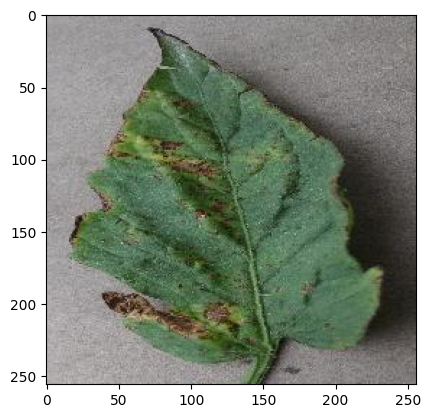

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='/content/drive/MyDrive/subset1/subset1/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'

result_inception = model_inception.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_inception,axis=1)
print(classes[classresult[0]])

**After disease detection fertilizer and precaution recommendation will be returned**

In [ ]:
import pandas as pd

dataset = pd.read_excel('/content/ds.xlsx')

def get_recommendation_and_precautions(predic):
   disease_info = dataset[dataset['Disease'] == predic]

   if not disease_info.empty:
        fertilizer_recommendation = disease_info['Fertilizer'].iloc[0]
        precautions = disease_info['Precautions'].iloc[0]
        return fertilizer_recommendation, precautions
   else:
        return "No information available", "No information available"



In [ ]:
dataset.head()

,Disease,Fertilizer,Precautions
0,Tomato___Bacterial_spot,Organic fertilizers high in potassium,Apply copper-based fungicides. Remove and dest...
1,Tomato___Early_blight,Balanced fertilizer with higher nitrogen content,Remove and destroy affected leaves. Practice c...
2,Tomato___Late_blight,Fertilizer rich in phosphorus,Apply fungicides and remove infected plant par...
3,Tomato___Leaf_Mold,Fertilizer with a balanced N-P-K ratio,Prune lower leaves and provide good airflow. A...
4,Tomato___Septoria_leaf_spot,Nitrogen-rich fertilizer,Spray with insecticidal soap or neem oil. Remo...


In [ ]:
def get_recommendation_and_precautions(predicted_disease):
    disease_info = dataset[dataset["Disease"] == predicted_disease]

    if not disease_info.empty:
        fertilizer_recommendation = disease_info["Fertilizer"].values[0]
        precautions = disease_info["Precautions"].values[0]
        return fertilizer_recommendation, precautions
    else:
        return None, None

In [ ]:
import pandas as pd

data = {
    'Disease': ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold',
                'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites_Two-spotted_spider_mite',
                'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
                'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'],
    'Fertilizer': ['Organic fertilizers high in potassium', 'Balanced fertilizer with higher nitrogen content',
                   'Fertilizer rich in phosphorus', 'Fertilizer with a balanced N-P-K ratio',
                   'Nitrogen-rich fertilizer', 'Fertilizer with low nitrogen content',
                   'Slow-release fertilizer with micronutrients', 'High-phosphorus fertilizer',
                   'Fertilizer with balanced nutrients', 'No specific recommendation needed'],
    'Precautions': ['Apply copper-based fungicides. Remove and destroy infected plant parts.',
                    'Remove and destroy affected leaves. Practice crop rotation.',
                    'Apply fungicides and remove infected plant parts promptly.',
                    'Prune lower leaves and provide good airflow. Avoid overhead watering.',
                    'Spray with insecticidal soap or neem oil. Remove heavily infested plants.',
                    'Remove infected leaves and improve air circulation.',
                    'Spray with insecticidal soap or neem oil. Remove heavily infested plants.',
                    'Control whiteflies and other insect vectors. Remove and destroy infected plants.',
                    'Control aphids and other insect vectors. Remove and destroy infected plants.',
                    'Maintain proper watering and nutrient levels for healthy plants.']
}

dataset = pd.DataFrame(data)


In [ ]:
print(dataset[dataset['Disease'] == 'Tomato___Late_blight'])



                Disease                     Fertilizer  \
2  Tomato___Late_blight  Fertilizer rich in phosphorus   

                                         Precautions  
2  Apply fungicides and remove infected plant par...  


1/1 [==============================] - 0s 307ms/step
Tomato___Bacterial_spot


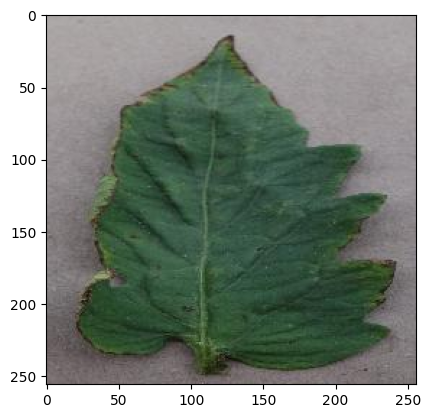

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='/content/drive/MyDrive/subset/Tomato___Bacterial_spot/01d9fc8d-5083-468d-a583-885f33517cdd___GCREC_Bact.Sp 3422.JPG'
result_cnn = model_cnn.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_cnn,axis=1)
predic=classes[classresult[0]]
print(classes[classresult[0]])

In [ ]:
fertilizer_recommendation, precautions = get_recommendation_and_precautions(predic)
print("Predicted Disease:", predic)
print("Fertilizer Recommendation:", fertilizer_recommendation)
print("Precautions:", precautions)

Predicted Disease: Tomato___Bacterial_spot
Fertilizer Recommendation: Organic fertilizers high in potassium
Precautions: Apply copper-based fungicides. Remove and destroy infected plant parts.


**Analysis**

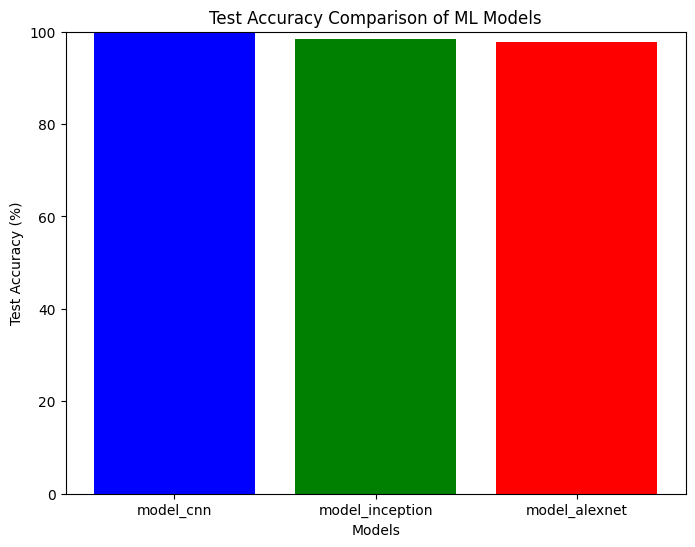

In [ ]:
plt.figure(figsize=(8, 6))
models=['model_cnn','model_inception','model_alexnet']
accuracies=[ 100.00 ,98.34, 97.85]
plt.bar(models, accuracies, color=['blue', 'green', 'red'])

# Adding title and labels
plt.title('Test Accuracy Comparison of ML Models')
plt.xlabel('Models')
plt.ylabel('Test Accuracy (%)')

# Display the plot
plt.ylim(0, 100)  # Set y-axis limits
plt.show()

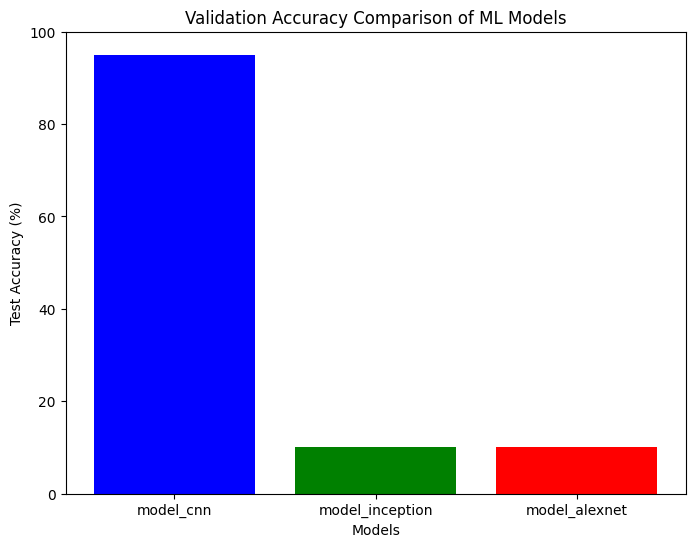

In [ ]:
plt.figure(figsize=(8, 6))
models=['model_cnn','model_inception','model_alexnet']
accuracies=[  95,10,10]
plt.bar(models, accuracies, color=['blue', 'green', 'red'])

# Adding title and labels
plt.title('Validation Accuracy Comparison of ML Models')
plt.xlabel('Models')
plt.ylabel('Test Accuracy (%)')

# Display the plot
plt.ylim(0, 100)  # Set y-axis limits
plt.show()